In [2]:
import Constants as c           # constants
import polars as pl             # polars
import os                       # for reading local files and folders
import zipfile                  # for handling zip files
from collections import Counter # for stats analysis on the dataframe  
import math                     # for math functions
import matplotlib.pyplot as plt # for plotting
import statistics as stats      # for statistics functions

Extract only the data with the correct latitude and longitude values</br>
This operation takes roughly 15-20 seconds per csv file (tested on csv files with > 1 million rows)</br>

In [3]:
final_df = pl.DataFrame()

# list all the valid files
valid_filenames = [f for f in os.listdir(c.FOLDER_PATH) if f.startswith('AIS')]
valid_filenames.sort()
csv_filenames = [f.removesuffix('.csv') for f in valid_filenames if f.endswith('.csv')]
zip_filenames = [f.removesuffix('.zip') for f in valid_filenames if f.endswith('.zip')]

already_unzipped = [f + '.zip' for f in csv_filenames]
stored_names, to_unzip_filenames = [], []

if c.LOG_FILE_NAME not in os.listdir(c.FOLDER_PATH):
    with open(file=c.FOLDER_PATH + c.LOG_FILE_NAME, mode='w') as f:
        for filename in already_unzipped:
            f.write(filename + '\n')
        print('log file created! Run this code again to extact the zip files and import them into a dataframe')

else:
    with open(file=c.FOLDER_PATH + c.LOG_FILE_NAME, mode='r+') as f:
        stored_names = [line.rstrip() for line in f]
        to_unzip_filenames = [f + '.zip' for f in zip_filenames if not(f in stored_names)]
        for zip_name in to_unzip_filenames:
            print(f'Unzipping file {zip_name}...')
            with zipfile.ZipFile(c.FOLDER_PATH + zip_name, 'r') as z:
                z.extractall(c.FOLDER_PATH)
                print(f'Writing filename: {zip_name} to log file')
                f.write(zip_name + '\n')
        for csv_name in [f for f in valid_filenames if f.startswith('AIS') and f.endswith('.csv')]:
            print(f'Importing and cleaning csv: {csv_name}')
            full_df = pl.read_csv(source=c.FOLDER_PATH + csv_name,
                                try_parse_dates=True,
                                low_memory = True
                                )
            filtered_df = full_df.filter(
                                        (pl.col('LAT').is_between(c.LAT_MIN, c.LAT_MAX, closed='none')) &
                                        (pl.col('LON').is_between(c.LON_MIN, c.LON_MAX, closed='none'))
                                        )

            final_df = pl.concat([final_df, filtered_df], how='vertical')

        for filename in to_unzip_filenames:
            print(f'Deleting unzipped file {filename}')
            os.unlink(c.FOLDER_PATH + filename)

print(final_df.shape)


Extracting and cleaning csv: AIS_2019_01_01.csv
Extracting and cleaning csv: AIS_2019_01_02.csv
Extracting and cleaning csv: AIS_2019_01_03.csv
Extracting and cleaning csv: AIS_2019_01_04.csv
Extracting and cleaning csv: AIS_2019_01_05.csv
Extracting and cleaning csv: AIS_2019_01_06.csv
Extracting and cleaning csv: AIS_2019_01_07.csv
Extracting and cleaning csv: AIS_2019_01_08.csv
Extracting and cleaning csv: AIS_2019_01_09.csv
Extracting and cleaning csv: AIS_2019_01_10.csv
Extracting and cleaning csv: AIS_2019_01_11.csv
Extracting and cleaning csv: AIS_2019_01_12.csv
Extracting and cleaning csv: AIS_2019_01_13.csv
Extracting and cleaning csv: AIS_2019_01_14.csv
Extracting and cleaning csv: AIS_2019_01_15.csv
Extracting and cleaning csv: AIS_2019_01_16.csv
Extracting and cleaning csv: AIS_2019_01_17.csv
Extracting and cleaning csv: AIS_2019_01_18.csv
Extracting and cleaning csv: AIS_2019_01_19.csv
Extracting and cleaning csv: AIS_2019_01_20.csv
Extracting and cleaning csv: AIS_2019_01

Separate code snippet used for exporting the final dataframe as a csv file.</br>
This is necessary as the above code snippet takes a while to read and filter several csv files.</br>
By exporting the resulting df as a csv file it's possible import it again for the following part of this notebook.</br>

In [3]:
#OUTPUT_PATH = os.getcwd() # returns current working dir
OUTPUT_PATH = c.FOLDER_PATH
FILE_NAME = '2019_01-05.csv' #specify file name (.csv extension necessary)

In [5]:
# export the full, uncleaned csv for backup purposes
final_df.write_csv(OUTPUT_PATH + '/' + FILE_NAME)

print(f"Dataframe shape: {final_df.shape}")

Dataframe shape: (9528400, 17)


Read the csv file and use it as the final data source</br>
(The code snippet below should be used only if the code snippet #2 was not executed)

In [4]:
# read csv
final_df = pl.read_csv(OUTPUT_PATH + FILE_NAME)
print(f'Rows, col before: {final_df.shape}')
final_df = final_df.unique()
print(f'Rows, col after: {final_df.shape}')

Rows, col before: (9528400, 17)
Rows, col after: (9525832, 17)


Some stats about the imported dataframe</br>
In order to make the histogram below, occurrencies are rounded to the top hundred (ex: 33 -> 100, 244 -> 300, etc...)</br>
This is done in order to have an idea about how many ships have negligible amount of records.</br>
In the following code snippet the threshold is set to 100 and consequently all vessels with less than 100 data points are removed from the dataset</br>

Avg entries for each vessel 12196.967989756722
Variance: 523944601.65666634
Standard Deviation: 22889.836208602854
Max entries found for the same ship: 144554
Min entries found for the same ship: 1


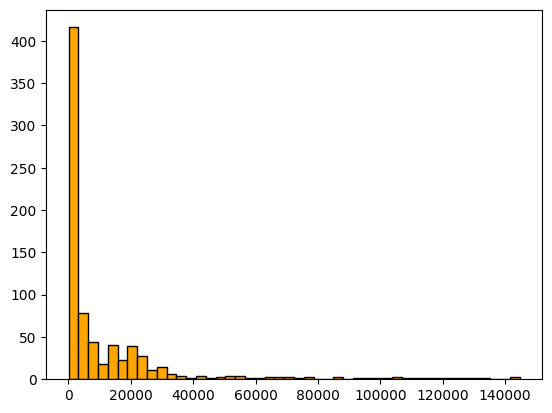

In [5]:
# Extract all the unique MMSIs
unique_mmsis = final_df['MMSI'].unique()

# Calculate the exact number of entries for each ship

vessels_entries_dict = dict(Counter(final_df['MMSI'].to_list()))
vessel_entries = list(vessels_entries_dict.values())
vessel_entries.sort()
rounded_vessel_entries = [math.ceil(x/100) * 100 for x in vessel_entries]

print(f"Avg entries for each vessel {stats.mean(vessel_entries)}")
print(f"Variance: {stats.variance(vessel_entries)}")
print(f"Standard Deviation: {stats.stdev(vessel_entries)}")
print(f"Max entries found for the same ship: {vessel_entries[-1]}")
print(f"Min entries found for the same ship: {vessel_entries[0]}")

n, bins, patches = plt.hist(x=rounded_vessel_entries, bins='auto', color='orange', edgecolor = 'black')

Remove ships with not enough points

In [6]:
THRESHOLD = int(stats.mean(vessel_entries) * 0.1)  # 10% of the average entries per ship
print(f'Threshold: {THRESHOLD} rows')
# find the MMSIs of all the ships with more than THRESHOLD points
mmsi_to_be_kept = [x for x in vessels_entries_dict.keys() if vessels_entries_dict[x] > THRESHOLD]
print(f"Final dataframe len: {final_df.shape[0]}, num of vessels: {len(vessel_entries)}, num of vessels: {len(mmsi_to_be_kept)}")

clean_df = pl.DataFrame()
for mmsi in mmsi_to_be_kept:    
    temp_df = final_df.filter(pl.col('MMSI') == mmsi)
    clean_df = pl.concat([clean_df, temp_df])
    
print(f"Cleaned dataframe len: {clean_df.shape[0]}, num of vessels: {len(clean_df['MMSI'].unique())}")
print(f'Percentage of row dropped/total rows = {round((final_df.shape[0] - clean_df.shape[0])/final_df.shape[0] * 100, 2)}%')

Threshold: 1219 rows
Final dataframe len: 9525832, num of vessels: 781, num of vessels: 494
Cleaned dataframe len: 9449943, num of vessels: 494
Percentage of row dropped/total rows = 0.8%


Export the cleaned dataframe in order to have a backup copy in a csv file

In [7]:
#OUTPUT_PATH = os.getcwd()
OUTPUT_PATH = c.FOLDER_PATH
clean_df.write_csv(OUTPUT_PATH + '/cleaned_' + FILE_NAME)

print(f"Dataframe shape: {clean_df.shape}")

Dataframe shape: (9449943, 17)


Create a new histogram using the "cleaned" data from the clean_df

Avg entries for each vessel 19129.43927125506
Variance: 697848806.9405236
Standard Deviation: 26416.828101430416
Max entries found for the same ship: 144554
Min entries found for the same ship: 1228


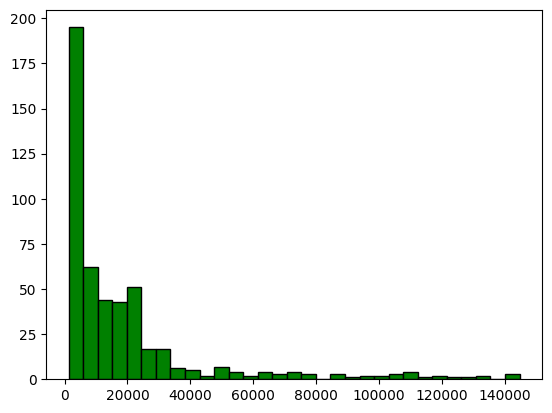

In [8]:
clean_vessel_entries = list(Counter(clean_df['MMSI'].to_list()).values())

rounded_clean_vessels_entries = [math.ceil(x/100) * 100 for x in clean_vessel_entries]

print(f"Avg entries for each vessel {stats.mean(clean_vessel_entries)}")
print(f"Variance: {stats.variance(clean_vessel_entries)}")
print(f"Standard Deviation: {stats.stdev(clean_vessel_entries)}")
print(f"Max entries found for the same ship: {max(clean_vessel_entries)}")
print(f"Min entries found for the same ship: {min(clean_vessel_entries)}")

n, bins, patches = plt.hist(x=rounded_clean_vessels_entries, bins='auto', color='green', edgecolor = 'black', )

### Denmark Dataset
Import data from a completely new dataset (already "cleaned") to test the algorithm in a new scenario


In [8]:
file='denmark_2023-06-05_point-based.parquet'
df = pl.read_parquet(c.FOLDER_PATH + c.DENMARK + file)

In [9]:
# Rename columns to the same naming scheme used in the Hawaii DataFrame
display(df.head(1))

t,transtype,vid,lat,lon,navstatus,rot,sog,cog,heading,imo,callsign,name,shiptype,cargotype,width,length,gpstype,draught,dest,eta,datasource,A,B,C,D,t_1,latr,lonr,havr_dist,speed_calc,journey,t_2,report_rate,heading_custom,rot_avg,rot_diff,speed_avg,speed_diff,__index_level_0__
datetime[ns],str,i64,f64,f64,str,f64,f64,f64,f64,str,str,str,str,str,f64,f64,str,f64,str,str,str,f64,f64,f64,f64,duration[ns],f64,f64,f64,f64,i64,duration[ns],f64,f64,f64,f64,f64,f64,i64
2023-05-06 13:11:54,"""Class A""",205096000,55.6581,5.47449,"""Under way using engine""",null,2.7,291.0,298.0,"""9898668""","""OPAS""","""Z19 BRIGITTE""","""Fishing""",null,8.0,34.0,"""GPS""",5.2,"""ZEEBRUGGE""","""26/04/2024 13:30:00""","""AIS""",12.0,22.0,6.0,2.0,null,0.971417,0.095548,null,null,35,null,null,null,null,null,null,null,1299


In [10]:
new_names = {
                "t":"BaseDateTime", "transtype":"TransceiverClass", "vid":"MMSI", "lat":'LAT', 'lon':'LON', 'navstatus':'Status', 'rot':'ROT',
                'sog':'SOG', 'cog':'COG', 'heading':'Heading', 'imo':'IMO', 'callsign':'CallSign', 'name':'VesselName',
                'shiptype':'VesselType', 'cargotype':'Cargo', 'width':'Width', 'length':'Length', 'gpstype':'GPSType', 
                'draught':'Draft', 'dest':'Destination', 'eta':'ETA', 'datasource':'Datasource'
            }
df = df.rename(new_names)
display(df.head(1))

BaseDateTime,TransceiverClass,MMSI,LAT,LON,Status,ROT,SOG,COG,Heading,IMO,CallSign,VesselName,VesselType,Cargo,Width,Length,GPSType,Draft,Destination,ETA,Datasource,A,B,C,D,t_1,latr,lonr,havr_dist,speed_calc,journey,t_2,report_rate,heading_custom,rot_avg,rot_diff,speed_avg,speed_diff,__index_level_0__
datetime[ns],str,i64,f64,f64,str,f64,f64,f64,f64,str,str,str,str,str,f64,f64,str,f64,str,str,str,f64,f64,f64,f64,duration[ns],f64,f64,f64,f64,i64,duration[ns],f64,f64,f64,f64,f64,f64,i64
2023-05-06 13:11:54,"""Class A""",205096000,55.6581,5.47449,"""Under way using engine""",null,2.7,291.0,298.0,"""9898668""","""OPAS""","""Z19 BRIGITTE""","""Fishing""",null,8.0,34.0,"""GPS""",5.2,"""ZEEBRUGGE""","""26/04/2024 13:30:00""","""AIS""",12.0,22.0,6.0,2.0,null,0.971417,0.095548,null,null,35,null,null,null,null,null,null,null,1299


In [ ]:
df = df.drop(['ROT', 'GPSType', 'Destination', 'ETA', 'Datasource', 'A', 'B', 'C', 'D', 't_1', 'latr', 'lonr'])
df = df.drop(['havr_dist', 'speed_calc', 'journey', 't_2', 'report_rate', 'heading_custom', 'rot_avg', 'rot_diff'])
df = df.drop(['speed_avg', 'speed_diff'])
#display(df.group_by("VesselType").agg(pl.len()))
pl.enable_string_cache()
df = df.with_columns(pl.col('VesselType').cast(pl.Categorical))
display(df.head(1))

BaseDateTime,TransceiverClass,MMSI,LAT,LON,Status,SOG,COG,Heading,IMO,CallSign,VesselName,VesselType,Cargo,Width,Length,Draft,__index_level_0__
datetime[ns],str,i64,f64,f64,str,f64,f64,f64,str,str,str,cat,str,f64,f64,f64,i64
2023-05-06 13:11:54,"""Class A""",205096000,55.6581,5.47449,"""Under way using engine""",2.7,291.0,298.0,"""9898668""","""OPAS""","""Z19 BRIGITTE""","""Fishing""",null,8.0,34.0,5.2,1299


In [18]:
display(len(df.group_by("VesselType").agg(pl.len())))
display(len(df.group_by("Status").agg(pl.len())))
display(len(df.group_by("Cargo").agg(pl.len())))

25

14

7

In [ ]:
#display(df.group_by("VesselType").agg(pl.len()))